### Setup

In [1]:
!pip install pandas
!pip install numpy
!pip install gensim
!pip install keras
!pip install scikit-learn
!pip install tensorflow

  Using cached gensim-4.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)


In [2]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

2023-04-29 12:37:43.216289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data

In [3]:
kaggle_data = pd.read_csv("https://raw.githubusercontent.com/lodi-m/u-integrity/main/data/normalized_scores/normalized_kaggle_essay_set.csv")
kaggle_data.head(5)

,Essay_id,Essay_set_id,Essay,rater1_domain1,rater2_domain1,domain1_score,normalized_score
0,1,1,dear local newspap think effect comput peopl g...,4.0,4.0,8.0,0.6
1,2,1,dear believ use comput benefit us mani way lik...,5.0,4.0,9.0,0.7
2,3,1,dear peopl use comput everyon agre benefit soc...,4.0,3.0,7.0,0.5
3,4,1,dear local newspap found mani expert say compu...,5.0,5.0,10.0,0.8
4,5,1,dear know comput posit effect people. comput c...,4.0,4.0,8.0,0.6


### LSTM model

In [21]:
from tensorflow.keras.optimizers import RMSprop
def get_lstm(loss):
    # initializing an empty neural network model layer by layer in a sequential manner
    model = Sequential()
    
    model.add(LSTM(200, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 200], return_sequences=True))
    model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4))
    model.add(Dense(1, activation='relu'))

    model.compile(loss=loss, optimizer='rmsprop', metrics=['mae'])
#     model.compile(optimizer=RMSprop(learning_rate = 0.0009), loss=tf.keras.losses.MeanAbsolutePercentageError(), metrics=['mae'])
    model.summary()

    return model

### Word2Vec

In [5]:
def get_w2v(df, min_word_count, num_features, num_workers, max_distance, downsample):
  w2v = Word2Vec(workers=num_workers, vector_size=num_features, min_count=min_word_count, window=max_distance, sample=downsample)

  w2v.build_vocab(df, progress_per=progress_val)
  w2v.train(df, total_examples=w2v.corpus_count, epochs=w2v.epochs)

  return w2v

### Word embeddings

In [6]:
def make_feature_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features, ))
    index_keys = set(model.wv.index_to_key)
    
    for word in words:
      if word in index_keys:
        feature_vector = np.add(feature_vector, model.wv[word])
    return feature_vector

In [7]:
def avg_feature_vectors(essays, model, num_features):
    final_essay_vector = np.zeros((len(essays), num_features))
    
    for i in range(len(essays)):
        final_essay_vector[i] = make_feature_vectors(essays[i], model, num_features)
    return final_essay_vector

### Parameters

In [8]:
X = kaggle_data["Essay"]
y = kaggle_data["normalized_score"]

In [9]:
min_word_count = 8
num_features = 200
num_workers = 4
max_distance = 10
downsampling = 1e-3
progress_val = 2000

### Training LSTM

In [33]:
mse_results = []
mae_results = []
mpe_results = []

maemse_results = []
maemape_results = []

In [11]:
w2v = get_w2v(X, min_word_count, num_features, num_workers, max_distance, downsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clean_train_essays = X_train.to_list()
clean_test_essays = X_test.to_list()

train_vectors = avg_feature_vectors(clean_train_essays, w2v, num_features)
test_vectors = avg_feature_vectors(clean_test_essays, w2v, num_features)

train_vectors = np.array(train_vectors)
test_vectors = np.array(test_vectors)
  

In [12]:
from sklearn.preprocessing import MinMaxScaler
# Create scaler object
# scaler = MinMaxScaler()

# Fit scaler to training data and transform it
# train_vectors_scaled = scaler.fit_transform(train_vectors)
# test_vectors_scaled = scaler.transform(test_vectors)
  
train_vectors_scaled = np.reshape(train_vectors, (train_vectors.shape[0], 1, train_vectors.shape[1]))
test_vectors_scaled = np.reshape(test_vectors, (test_vectors.shape[0], 1, test_vectors.shape[1]))

In [35]:
# fit mse model and predict
lstm_model = get_lstm('mean_squared_error')
lstm_model.fit(train_vectors_scaled, y_train, batch_size=32, epochs=50)

y_pred_mse = lstm_model.predict(test_vectors_scaled)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_16 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_17 (LSTM)              (None, 50)                30200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 471,451
Trainable params: 471,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
129/129 [==============================] - 6s 9ms/step - loss: 0.0452 - mae: 0.1645
Epoch 2/50
129/129 [==============================] - 1s 8ms/step - loss: 0.0346 - ma

In [31]:
# fit mae model and predict
lstm_model = get_lstm('mean_absolute_error')
lstm_model.fit(train_vectors_scaled, y_train, batch_size=32, epochs=50)

y_pred_mae = lstm_model.predict(test_vectors_scaled)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_10 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 471,451
Trainable params: 471,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
129/129 [==============================] - 6s 9ms/step - loss: 0.1680 - mae: 0.1680
Epoch 2/50
129/129 [==============================] - 1s 8ms/step - loss: 0.1443 - ma

In [32]:
# fit mape model and predict
lstm_model = get_lstm(tf.keras.losses.MeanAbsolutePercentageError())
lstm_model.fit(train_vectors_scaled, y_train, batch_size=32, epochs=50)

y_pred_mape = lstm_model.predict(test_vectors_scaled)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_13 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_14 (LSTM)              (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 471,451
Trainable params: 471,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
129/129 [==============================] - 7s 9ms/step - loss: 180597.5000 - mae: 0.5882
Epoch 2/50
129/129 [==============================] - 1s 8ms/step - loss: 4765.6

In [37]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = mean_squared_error(y_test, y_pred_mse)
mpe = mape(y_test, y_pred_mape).numpy()
mae = mean_absolute_error(y_test, y_pred_mae)
maemse = mean_absolute_error(y_test, y_pred_mse)
maemape = mean_absolute_error(y_test, y_pred_mape)

mse_results.append(mse)
mpe_results.append(mpe)
mae_results.append(mae)

maemse_results.append(maemse)
maemape_results.append(maemape)

In [43]:
print(np.around(np.array(mse_results).mean(), decimals=4))
print(np.around(np.array(mpe_results).mean(), decimals=4))
print(np.around(np.array(mae_results).mean(), decimals=4))

0.0261
99.4894
0.128


In [45]:
print(np.around(np.array(maemse_results).mean(), decimals=4))
print(np.around(np.array(maemape_results).mean(), decimals=4))

0.127
0.6178


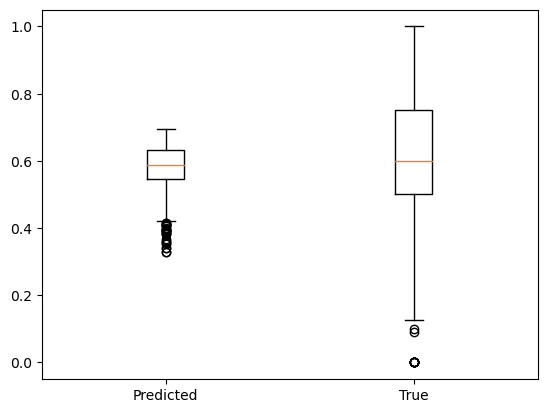

In [46]:
import matplotlib.pyplot as plt

# Create box plot of predicted and true values
data = [y_pred.flatten(), y_test.values.flatten()]
plt.boxplot(data, labels=['Predicted', 'True'])
plt.show()

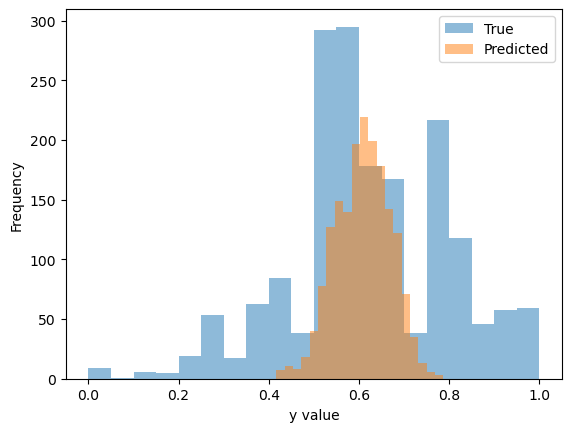

In [55]:
import matplotlib.pyplot as plt

# Create histogram of true y values
plt.hist(y_test, bins=20, alpha=0.5, label='True')

# Create histogram of predicted y values
plt.hist(y_pred_mse, bins=20, alpha=0.5, label='Predicted')

# Add axis labels and a legend
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

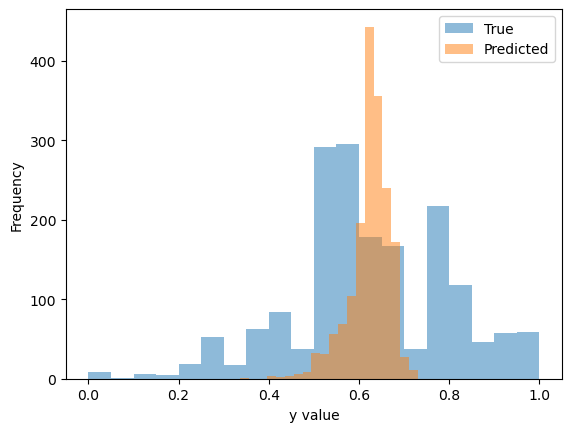

In [56]:
import matplotlib.pyplot as plt

# Create histogram of true y values
plt.hist(y_test, bins=20, alpha=0.5, label='True')

# Create histogram of predicted y values
plt.hist(y_pred_mae, bins=20, alpha=0.5, label='Predicted')

# Add axis labels and a legend
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

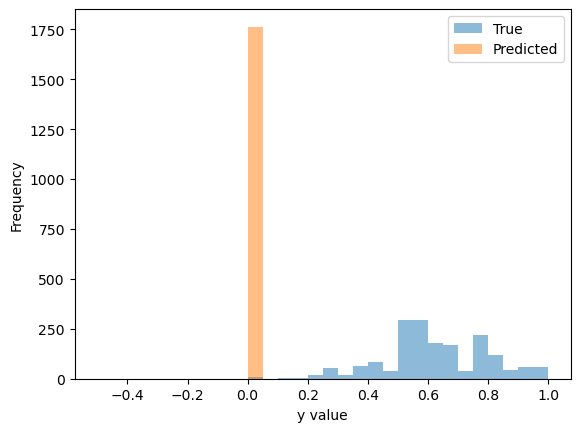

In [57]:
import matplotlib.pyplot as plt

# Create histogram of true y values
plt.hist(y_test, bins=20, alpha=0.5, label='True')

# Create histogram of predicted y values
plt.hist(y_pred_mape, bins=20, alpha=0.5, label='Predicted')

# Add axis labels and a legend
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [48]:
y_pred_mse.mean()

0.6086117

In [49]:
y_test.mean()

0.6178461300469241

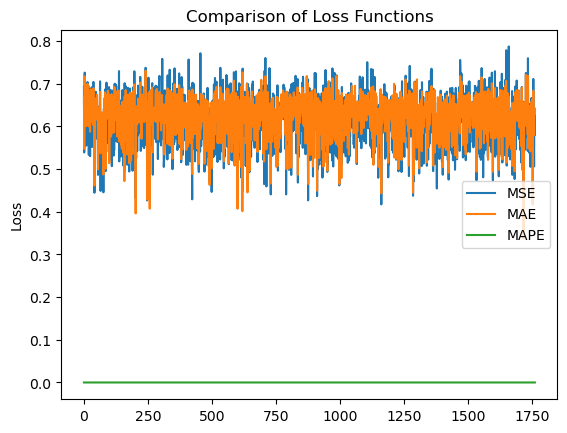

In [67]:
# Plot both loss functions on the same graph
plt.plot(y_pred_mse, label='MSE')
plt.plot(y_pred_mae, label='MAE')
plt.plot(y_pred_mape, label='MAPE')

# Add a legend and labels
plt.legend()
plt.title('Comparison of Loss Functions')
plt.ylabel('Loss')
plt.show()